# None-Linear Image Filter

While linear image filters can effeciently remove noise from some images, sometimes it doesn't work as well. For instance, an image with "salt and pepper" noise.

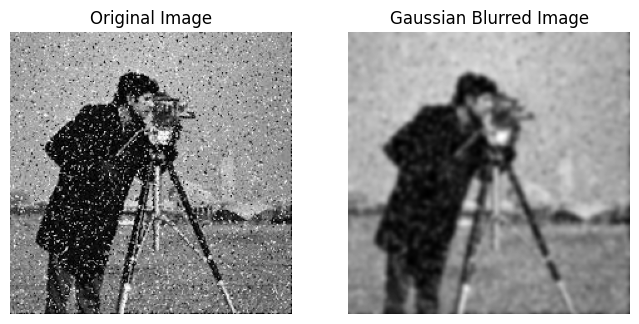

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open("../img/salt_and_pepper.jpeg").convert("L")
img_np = np.array(img, dtype=np.float32)

def gaussian_kernel(size: int, sigma: float) -> np.ndarray:
    ax = np.linspace(start=-(size // 2), stop=size // 2, num=size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)


def convolve2d(image: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """Apply 2D convolution between an image and a kernel (without padding)."""
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2

    # Pad the image
    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='edge')

    # Output image
    result = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            region = padded[i:i+kernel_h, j:j+kernel_w]
            result[i, j] = np.sum(region * kernel)

    return result

size = 10
sigma = 2
kernel = gaussian_kernel(size=size, sigma=sigma)
blurred = convolve2d(img_np, kernel)

# Display original and blurred images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(blurred, cmap='gray')
plt.title(f"Gaussian Blurred Image")
plt.axis('off')
plt.show()

---
## 1. Median Filter

1. Sort the $k^2$ values in window centered at the pixel
2. Assign the median to that pixel

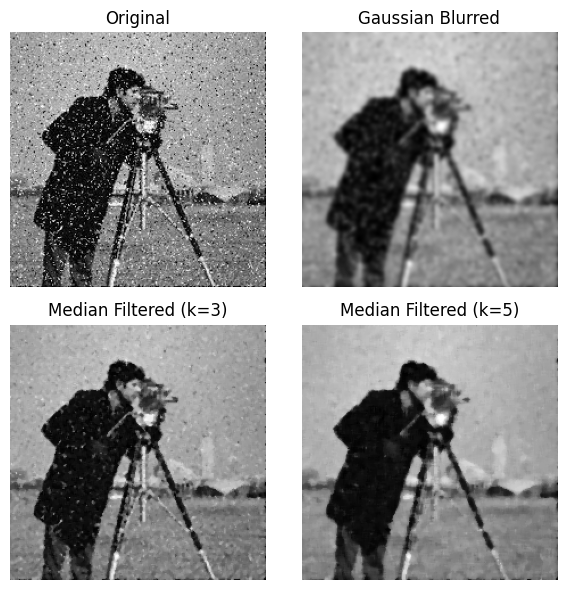

In [6]:
def median_filter(image: np.ndarray, k: int):
    assert k % 2 == 1, "Kernel size must be odd"
    pad = k // 2
    image_h, image_w = image.shape

    # Pad the image
    padded = np.pad(image, pad, mode='edge')

    # Output image
    result = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            window = padded[i:i+k, j:j+k].flatten()
            median_val = np.median(window)
            result[i, j] = median_val
    return result

image_k_3 = median_filter(img_np, 3)
image_k_5 = median_filter(img_np, 5)

# Show all images
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes[0, 0].imshow(img_np, cmap="gray")
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")

axes[0, 1].imshow(blurred, cmap="gray")
axes[0, 1].set_title("Gaussian Blurred")
axes[0, 1].axis("off")

axes[1, 0].imshow(image_k_3, cmap="gray")
axes[1, 0].set_title("Median Filtered (k=3)")
axes[1, 0].axis("off")

axes[1, 1].imshow(image_k_5, cmap="gray")
axes[1, 1].set_title("Median Filtered (k=5)")
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

---
## 2. Bilateral Filter

A linear Guassian kernel is great at smoothing the image. But at the same time, the edges within the image can be smoothed out. In some cases, we want to preserve the edge while reducing the noise. And a bilateral filter is perfect for this. Let's revisit the regular guassian kernel first:

$$
g[i, j] = \frac{1}{W^s} \sum_{m=1}^{K} \sum_{n=1}^{K} \; f[m, n] \; n_{\sigma_s}[i-m, j-n]
$$

where 
  
&nbsp;&nbsp;&nbsp;&nbsp;$\frac{1}{W^s}$ is the normalization term
  
&nbsp;&nbsp;&nbsp;&nbsp;$n_{\sigma_s}[i-m, j-n]$ is the spatial (or domain) kernel for smoothing differences in coordinates

The original kernel will smooth out the edge in the following example:
![Guaasian Kernel Effect On Edge](../img/bilateral_1.png)

The solution to this is to add another term to the guassian kernel as following:

$$
g[i, j] = \frac{1}{W^{sb}} \sum_{m=1}^{K} \sum_{n=1}^{K} \; f[m, n] \; n_{\sigma_s}[i-m, j-n] \; n_{\sigma_b}(f[m, n] - f[i, j])
$$

where 
  
&nbsp;&nbsp;&nbsp;&nbsp;$n_{\sigma_b}(f[m, n] = f[i, j])$ is the sum of the brightness difference between the pixel we're acting on $(i, j)$ and the neighboring pixels $(m, n)

By combining the two guassians, we get the following result:
![Bilateral Kernel Effect On Edge](../img/bilateral_2.png)

To summarize the formula. The bilateral filter is defined as:

$$
g[i, j] = \frac{1}{W^{sb}} \sum_{m=1}^{K} \sum_{n=1}^{K} \; f[m, n] \; n_{\sigma_s}[i-m, j-n] \; n_{\sigma_b}(f[m, n] - f[i, j])
$$

where 

&nbsp;&nbsp;&nbsp;&nbsp;$n_{\sigma_s}[m, n] = \frac{1}{2\pi\sigma^2_s}e^{-\frac{1}{2}\frac{m^2+n^2}{\sigma^2_s}}$

&nbsp;&nbsp;&nbsp;&nbsp;$n_{\sigma_b}(k) = \frac{1}{\sqrt{2\pi}\sigma_b}e^{-\frac{1}{2}\frac{k^2}{\sigma^2_b}}$

&nbsp;&nbsp;&nbsp;&nbsp;$W_{sb} = \sum_{m=1}^{K} \sum_{n=1}^{K} \; n_{\sigma_s}[i-m, j-n] \; n_{\sigma_b}(f[m, n] - f[i, j]$

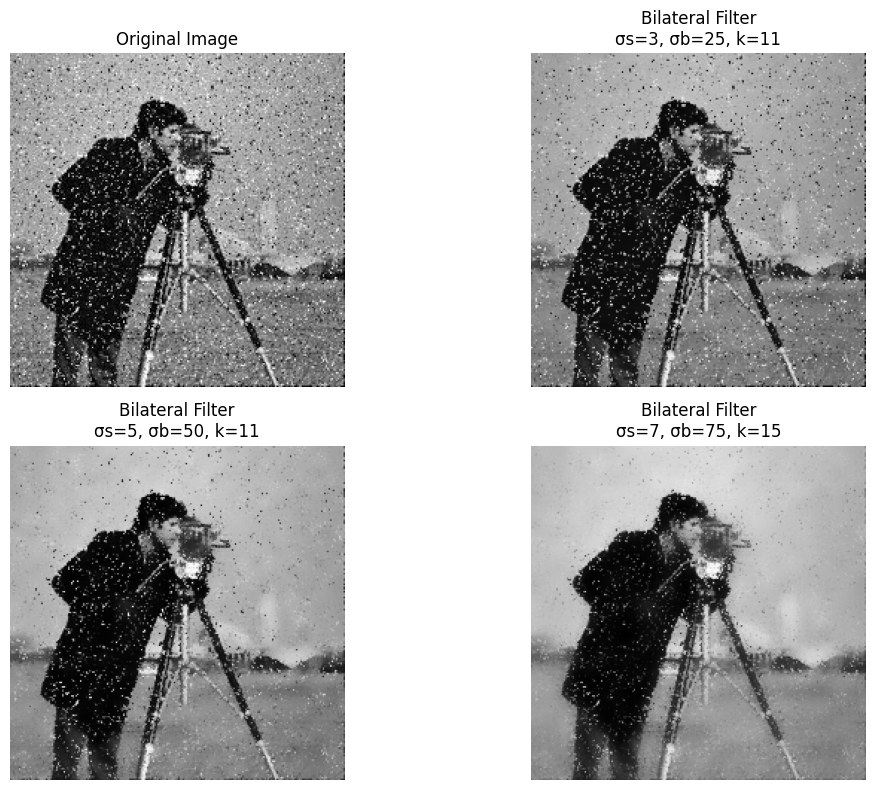

In [7]:
def bilateral_filter(image: np.ndarray, k: int, sigma_s: float, sigma_b: float) -> np.ndarray:
    """
    Apply a bilateral filter to a grayscale image.
    
    Parameters:
        image (np.ndarray): Grayscale input image (2D).
        k (int): Diameter of the filter window (must be odd).
        sigma_s (float): Spatial standard deviation (distance weighting).
        sigma_b (float): Range standard deviation (brightness weighting).
    
    Returns:
        np.ndarray: Bilaterally filtered image.
    """
    image_h, image_w = image.shape

    # Precompute spatial Gaussian kernel
    half = k // 2
    x = np.arange(-half, half + 1)
    y = np.arange(-half, half + 1)
    xx, yy = np.meshgrid(x, y)
    spatial_gaussian = np.exp(-(xx**2 + yy**2) / (2 * sigma_s**2))

    padded = np.pad(image, half, mode='reflect')

    filtered = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            region = padded[i:i+k, j:j+k]

            # Range Gaussian (based on intensity difference)
            brightness_diff = region - image[i, j]
            brightness_gaussian = np.exp(-(brightness_diff**2) / (2 * sigma_b**2))

            # Combined weight
            weights = spatial_gaussian * brightness_gaussian
            weights /= np.sum(weights)

            filtered[i, j] = np.sum(region * weights)
            
    return filtered
    

filtered_img1 = bilateral_filter(img_np, k=11, sigma_s=3, sigma_b=25)
filtered_img2 = bilateral_filter(img_np, k=11, sigma_s=5, sigma_b=50)
filtered_img3 = bilateral_filter(img_np, k=15, sigma_s=7, sigma_b=75)

# Display original and blurred images
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(filtered_img1, cmap='gray')
plt.title("Bilateral Filter\nσs=3, σb=25, k=11")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(filtered_img2, cmap='gray')
plt.title("Bilateral Filter\nσs=5, σb=50, k=11")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(filtered_img3, cmap='gray')
plt.title("Bilateral Filter\nσs=7, σb=75, k=15")
plt.axis('off')

plt.tight_layout()
plt.show()